Source: https://learning.quantum.ibm.com/tutorial/chsh-inequality#create-a-list-of-phase-values-to-be-assigned-later

This code tests the CHSH game to verify the violation of Bell's inequality on IBM Quantum Computers. The CHSH (Clauser-Horne-Shimony-Holt) inequality is a fundamental test of quantum mechanics against local hidden variable theories.

The goal is to:

    - Create an entangled Bell state.
    - Perform measurements in different bases.
    - Compute expectation values of observables.
    - Compare them with classical limits.
    - Demonstrate CHSH violation using quantum computing.

### Step 1. Map classical inputs to a quantum problem

For this experiment, we will create an entangled pair on which we measure each qubit on two different bases.  
We will label the bases for the first qubit $A$ and $a$ and the bases for the second qubit $B$ and $b$.  
This allows us to compute the CHSH quantity $S_1$:

$$
S_1 = A(B - b) + a(B + b).
$$

Each observable is either $+1$ or $-1$. Clearly, one of the terms $B \pm b$ must be $0$, and the other must be $\pm 2$.  
Therefore, $S_1 = \pm 2$. The average value of $S_1$ must satisfy the inequality:

$$
|\langle S_1 \rangle| \leq 2.
$$

Expanding $S_1$ in terms of $A, a, B,$ and $b$ results in:

$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2
$$

You can define another CHSH quantity $S_2$:

$$
S_2 = A(B + b) - a(B - b),
$$

This leads to another inequality:

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2
$$

If quantum mechanics can be described by local hidden variable theories, the previous inequalities must hold true.  
However, as is demonstrated in this notebook, these inequalities can be violated in a quantum computer.  
Therefore, quantum mechanics is not compatible with local hidden variable theories.


You will create an entangled pair of qubits in a quantum computer by preparing the Bell state:

$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}.
$$

Using the Estimator primitive, you can directly obtain the expectation values:

$$
\langle AB \rangle, \quad \langle Ab \rangle, \quad \langle aB \rangle, \quad \langle ab \rangle
$$

These values help compute the CHSH quantities:

$$
\langle S_1 \rangle \quad \text{and} \quad \langle S_2 \rangle.
$$

Before the Estimator primitive, these values had to be computed manually from measurement outcomes.

### Measurement Process:
- The second qubit is measured in the $Z$ and $X$ bases.
- The first qubit is also measured in orthogonal bases.
- The second qubit’s measurement angle is varied between $0$ and $2\pi$.

The Estimator primitive simplifies this process by allowing a **single** CHSH circuit with a parameter for measurement angle. Rather than creating a series of CHSH circuits, you only need to create one CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

### Expected Results:
- You will plot the expectation values of $S_1$ and $S_2$ against the measurement angle.
- For some angles, **CHSH violations** occur:  

  $$
  |\langle S_1 \rangle| > 2 \quad \text{or} \quad |\langle S_2 \rangle| > 2.
  $$

This confirms that quantum mechanics **violates local hidden variable theories**.



In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="",
)
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_brisbane'

### Parameterized CHSH Circuit

First, we construct a CHSH circuit with a parameter $\theta$, called ``theta``.  

The ``Estimator`` primitive simplifies circuit creation and output analysis by directly providing expectation values of observables.  

Many problems, particularly in ``near-term noisy quantum systems``, are formulated in terms of expectation values.  

The ``Estimator (V2) primitive`` automatically adjusts the measurement basis based on the given observable, making computations more efficient.


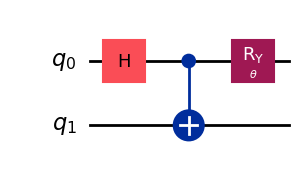

In [3]:
## The Hadamard (H) gate puts the first qubit into a superposition.
## The CNOT (CX) gate entangles the two qubits.
## The RY gate with a parameter theta allows changing the measurement basis dynamically.

theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### Create a List of Phase Values

After constructing the `parameterized CHSH circuit`, you will generate a list of `phase values` to be assigned in the next step.  

The following code creates `21` phase values ranging from `0` to $2\pi$ with equal spacing:

- $0, 0.1\pi, 0.2\pi, \dots, 1.9\pi, 2\pi$



In [4]:
number_of_phases = 20
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

individual_phases

[[np.float64(0.0)],
 [np.float64(0.3306939635357677)],
 [np.float64(0.6613879270715354)],
 [np.float64(0.992081890607303)],
 [np.float64(1.3227758541430708)],
 [np.float64(1.6534698176788385)],
 [np.float64(1.984163781214606)],
 [np.float64(2.3148577447503738)],
 [np.float64(2.6455517082861415)],
 [np.float64(2.9762456718219092)],
 [np.float64(3.306939635357677)],
 [np.float64(3.6376335988934447)],
 [np.float64(3.968327562429212)],
 [np.float64(4.29902152596498)],
 [np.float64(4.6297154895007475)],
 [np.float64(4.960409453036515)],
 [np.float64(5.291103416572283)],
 [np.float64(5.621797380108051)],
 [np.float64(5.9524913436438185)],
 [np.float64(6.283185307179586)]]

### Observables

To compute the **expectation values**, we need to define the **observables**.  

In this case, we use **orthogonal bases** for each qubit. The **parameterized** `Y−rotation` for the first qubit allows the measurement basis to sweep **continuously** with respect to the second qubit's basis.  

We choose the following observables:

- `ZZ`
- `ZX`
- `XZ`
- `XX`


In [5]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

## Step 2. Optimize problem for quantum execution
To reduce the total job execution time, V2 primitives only accept circuits and observables that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).

### ISA Circuit

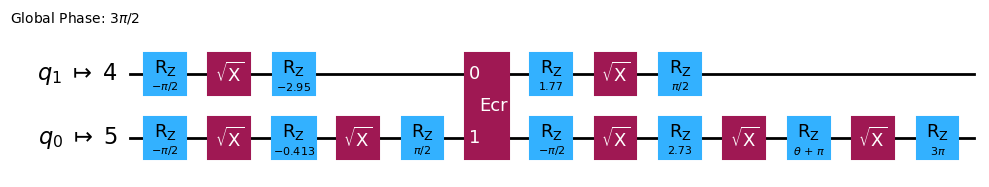

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# # Generate an optimized quantum circuit for the selected backend
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# Optimize the CHSH circuit
chsh_isa_circuit = pm.run(chsh_circuit)

# Visualize optimized circuit
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables
Similarly, we need to transform the observables to make it backend compatible before running jobs with 
Runtime Estimator V2
- We can perform the transformation using the ``apply_layout`` the method of ``SparsePauliOp`` object.

In [7]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)

## Step 3. Execute using Qiskit primitives
- In order to execute the entire experiment in one call to the ``Estimator``.
- We can create a Qiskit Runtime ``Estimator`` primitive to compute our expectation values.
- The ``EstimatorV2.run()`` method takes an iterable of ``primitive unified blocs (PUBs)``. Each PUB is an iterable in the format ``(circuit, observables, parameter_values: Optional, precision: Optional)``.

In [8]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = Estimator(mode=backend)

pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()

### Step 4: Post-process and Return Result in Classical Format

The **Estimator** returns expectation values for both observables:

$$
\langle ZZ \rangle - \langle ZX \rangle + \langle XZ \rangle + \langle XX \rangle
$$

and

$$
\langle ZZ \rangle + \langle ZX \rangle - \langle XZ \rangle + \langle XX \rangle.
$$

These values represent the measured correlations between qubits in different bases and are used to analyze the **CHSH inequality violation**.


In [9]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

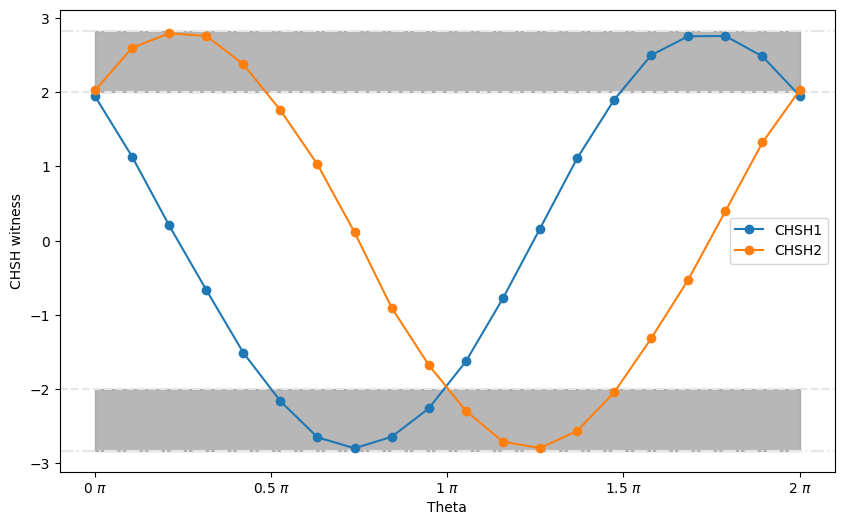

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

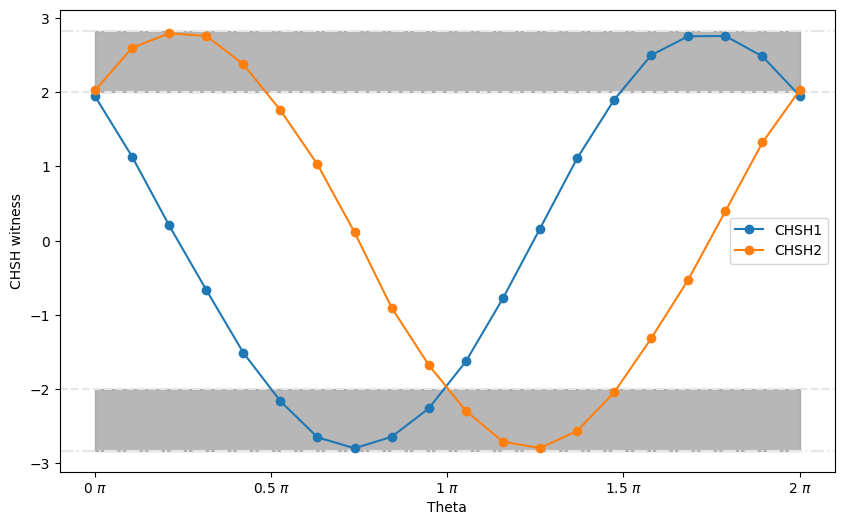

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

### Understanding the Figure: Quantum and Classical Bounds

In the figure, the ``lines and gray areas`` represent different bounds:

- The ``outer-most (dash-dotted) lines`` indicate the **quantum bounds** at **$\pm 2\sqrt{2}$**.
- The ``inner (dashed) lines`` indicate the **classical bounds** at **$\pm 2$**.

You can observe that there are regions where the **CHSH witness quantities exceed the classical bounds**, demonstrating the **violation of classical constraints** and confirming quantum mechanical predictions.
